<a href="https://colab.research.google.com/github/GOWSALYAR7397/-shopping-mod3-link/blob/main/lstm_my_project_crt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# ============================================================
# Section 1: Setup & Imports
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from prophet import Prophet

In [6]:
# ============================================================
# Section 2: Data Loading & Preprocessing
# ============================================================

!pip install yfinance --quiet

import yfinance as yf

# Download VIX index data directly
vix = yf.download("^VIX", start="2015-01-01", end="2025-01-01")

# Prepare dataframe with required columns
df = vix.reset_index()[["Date","Close"]].rename(columns={"Date":"ds","Close":"y"})

# Convert types
df['ds'] = pd.to_datetime(df['ds'])
df['y'] = df['y'].astype(float)

# Stationarity check
result = adfuller(df['y'])
use_diff = result[1] > 0.05

if use_diff:
    df['y_diff'] = df['y'].diff().dropna()
    series = df['y_diff'].dropna().values
else:
    series = df['y'].values

# Scale values
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.reshape(-1,1))

# Sequence construction
L, H = 80, 10   # input window length, forecast horizon
X, Y = [], []
for i in range(len(series_scaled)-L-H+1):
    X.append(series_scaled[i:i+L])
    Y.append(series_scaled[i+L:i+L+H])
X, Y = np.array(X), np.array(Y)

# Train/val/test split
train_size = int(0.7*len(X))
val_size   = int(0.15*len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val,   Y_val   = X[train_size:train_size+val_size], Y[train_size:train_size+val_size]
X_test,  Y_test  = X[train_size+val_size:], Y[train_size+val_size:]

print("Data prepared:")
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

/tmp/ipython-input-3247601501.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed

Data prepared:
Train: (1698, 80, 1) Val: (364, 80, 1) Test: (365, 80, 1)


In [15]:
# ============================================================
# Section 3: Vanilla Seq2Seq LSTM
# ============================================================

from tensorflow.keras import layers, Model, Input

def build_vanilla_seq2seq(L, H, units=128, dropout=0.3):
    """
    Vanilla Seq2Seq LSTM model:
    - Encoder: LSTM encodes input sequence
    - Decoder: LSTM generates H-step forecasts
    """
    # Encoder
    enc_inputs = Input(shape=(L,1))
    enc_out, state_h, state_c = layers.LSTM(units, return_state=True)(enc_inputs)

    # Decoder
    dec_inputs = layers.RepeatVector(H)(enc_out)
    dec_out = layers.LSTM(units, return_sequences=True, dropout=dropout)(
        dec_inputs, initial_state=[state_h, state_c]
    )

    # Output layer
    outputs = layers.TimeDistributed(layers.Dense(1))(dec_out)

    return Model(enc_inputs, outputs)

# Build model
vanilla_model = build_vanilla_seq2seq(L, H, units=128, dropout=0.3)

# Compile model
vanilla_model.compile(optimizer='adam', loss='mse')

# Train model and save history for later visualization
history_vanilla = vanilla_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

print("Vanilla Seq2Seq LSTM model trained successfully.")

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - loss: 0.0084 - val_loss: 0.0022
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 10/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 12/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step 

In [7]:
# ============================================================
# Section 4: Bahdanau Attention Layer
# ============================================================

class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super().__init__()
        # Dense layers to transform encoder and decoder hidden states
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V  = layers.Dense(1)

    def call(self, enc_out, dec_hidden):
        """
        enc_out: Encoder outputs (batch_size, seq_len, hidden_size)
        dec_hidden: Decoder hidden state (batch_size, hidden_size)
        """
        # Expand decoder hidden state to match encoder time dimension
        dec_hidden_exp = tf.expand_dims(dec_hidden, 1)

        # Compute alignment scores
        score = self.V(tf.nn.tanh(self.W1(enc_out) + self.W2(dec_hidden_exp)))

        # Attention weights (alpha)
        alpha = tf.nn.softmax(score, axis=1)

        # Context vector: weighted sum of encoder outputs
        context = tf.reduce_sum(alpha * enc_out, axis=1)

        return context, alpha

In [10]:
# ============================================================
# Section 5: Attention Seq2Seq LSTM
# ============================================================

# Make sure Input is imported
from tensorflow.keras import layers, Model, Input

# Define input window length and forecast horizon if not already defined
L, H = 80, 10   # adjust as needed

def build_attention_seq2seq(L, H, units=128, dropout=0.3):
    # Encoder
    enc_inputs = Input(shape=(L,1))
    enc_out, state_h, state_c = layers.LSTM(
        units, return_sequences=True, return_state=True, dropout=dropout
    )(enc_inputs)

    # Decoder initial states
    dec_h, dec_c = state_h, state_c
    step_outputs = []

    # Decoder loop for H forecast steps
    for _ in range(H):
        # Attention layer
        context, alpha = BahdanauAttention(units)(enc_out, dec_h)

        # Expand context using a Keras layer
        context_exp = layers.Reshape((1, units))(context)

        # Decoder LSTM step
        dec_out, dec_h, dec_c = layers.LSTM(
            units, return_state=True, dropout=dropout
        )(context_exp, initial_state=[dec_h, dec_c])

        # Dense output for this step
        step_y = layers.Dense(1)(dec_out)
        step_outputs.append(step_y)

    # Concatenate outputs along time axis
    outputs = layers.Concatenate(axis=1)(step_outputs)

    return Model(enc_inputs, outputs)

# Build, compile, and train the Attention model
attn_model = build_attention_seq2seq(L, H, units=128, dropout=0.3)
attn_model.compile(optimizer='adam', loss='mse')

history_attn = attn_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

print("Attention-LSTM model trained successfully.")

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 294ms/step - loss: 0.0129 - val_loss: 0.0059
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 237ms/step - loss: 0.0080 - val_loss: 0.0044
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 292ms/step - loss: 0.0059 - val_loss: 0.0106
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 231ms/step - loss: 0.0068 - val_loss: 0.0045
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 241ms/step - loss: 0.0064 - val_loss: 0.0094
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - loss: 0.0077 - val_loss: 0.0039
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 234ms/step - loss: 0.0072 - val_loss: 0.0057
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 232ms/step - loss: 0.0064 - val_loss: 0.0049
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 231ms/step - loss: 0.0060 - val_loss: 0.0048
Epoch 10/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 238ms/step - loss: 0.0059 - val_loss: 0.0065
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 239ms/step - loss: 0.0055 - val_loss: 0.0090
Epoch 12/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 13

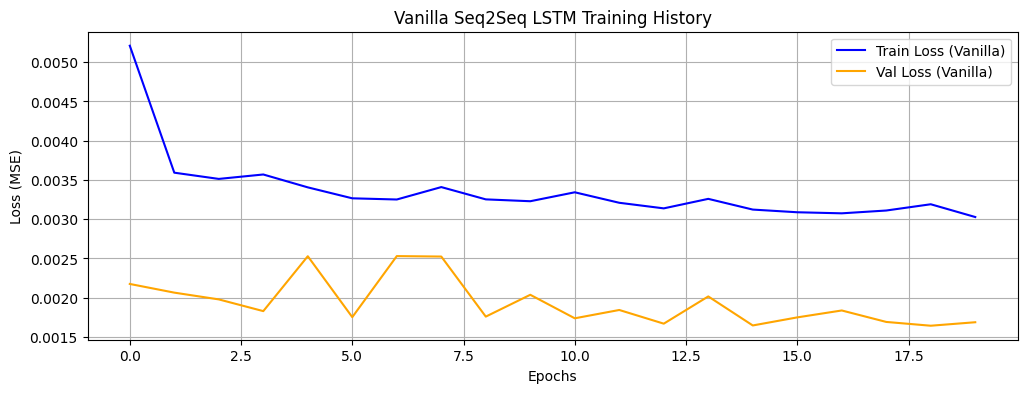

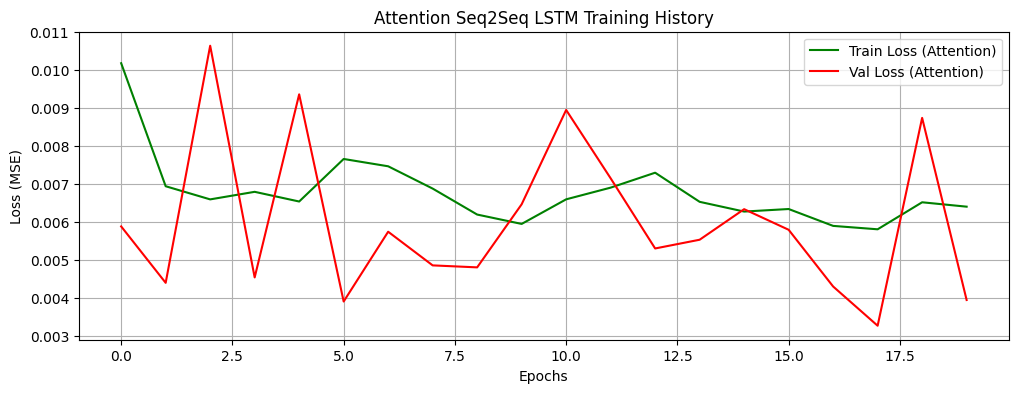

In [16]:
# ============================================================
# Section 6: Training Evaluation & Visualization
# ============================================================

# Plot training history for Vanilla LSTM
plt.figure(figsize=(12,4))
plt.plot(history_vanilla.history['loss'], label='Train Loss (Vanilla)', color='blue')
plt.plot(history_vanilla.history['val_loss'], label='Val Loss (Vanilla)', color='orange')
plt.title("Vanilla Seq2Seq LSTM Training History")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

# Plot training history for Attention LSTM
plt.figure(figsize=(12,4))
plt.plot(history_attn.history['loss'], label='Train Loss (Attention)', color='green')
plt.plot(history_attn.history['val_loss'], label='Val Loss (Attention)', color='red')
plt.title("Attention Seq2Seq LSTM Training History")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


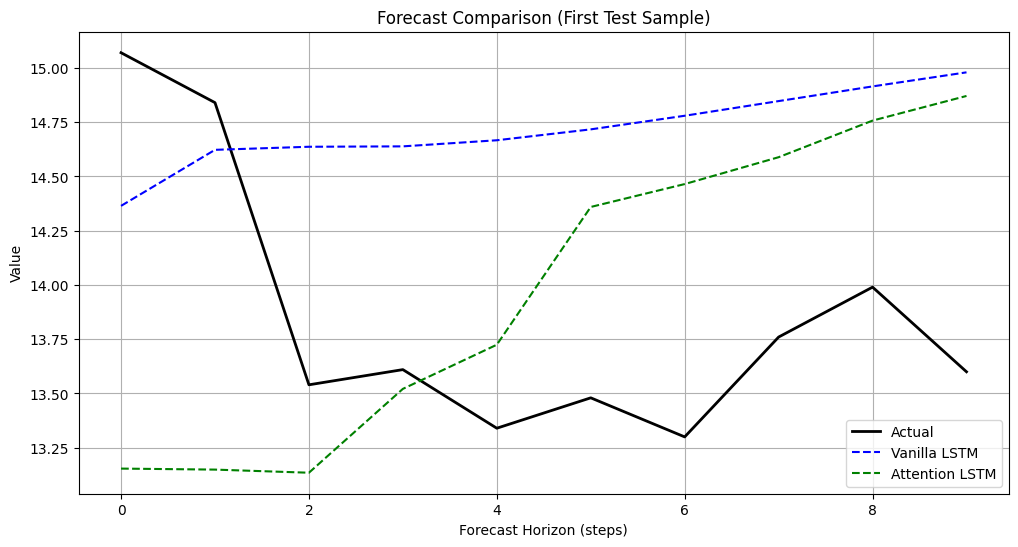

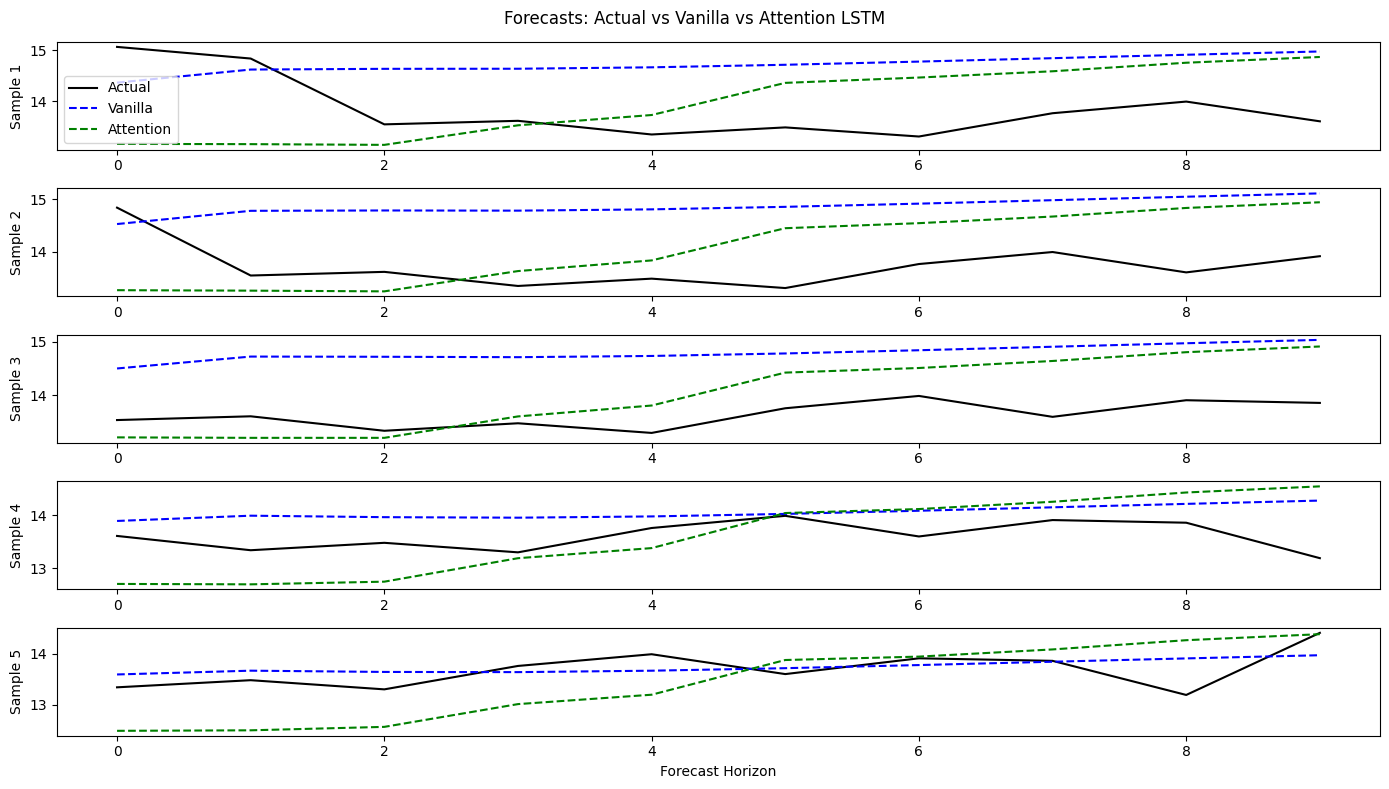

In [19]:
# ============================================================
# Section 7: Forecast Visualization
# ============================================================

# Get predictions from both models
pred_vanilla_scaled = vanilla_model.predict(X_test, verbose=0)   # shape: (batch, H, 1)
pred_attn_scaled    = attn_model.predict(X_test, verbose=0)      # shape: (batch, H)

# Inverse scale predictions and ground truth

# For Vanilla LSTM (3D predictions)
def inverse_scale_preds_3d(pred_scaled, scaler):
    b,h,c = pred_scaled.shape
    flat = pred_scaled.reshape(-1,1)
    inv = scaler.inverse_transform(flat).reshape(b,h,c)
    return inv

# For Attention LSTM (2D predictions)
def inverse_scale_preds_2d(pred_scaled, scaler):
    b,h = pred_scaled.shape
    flat = pred_scaled.reshape(-1,1)
    inv = scaler.inverse_transform(flat).reshape(b,h,1)
    return inv

# For ground truth (Y_test is usually 3D: batch,horizon,1)
def inverse_scale_truth(y_scaled, scaler):
    b,h,c = y_scaled.shape
    flat = y_scaled.reshape(-1,1)
    inv = scaler.inverse_transform(flat).reshape(b,h,c)
    return inv

# Apply inverse scaling
Y_test_inv       = inverse_scale_truth(Y_test, scaler)
pred_vanilla_inv = inverse_scale_preds_3d(pred_vanilla_scaled, scaler)
pred_attn_inv    = inverse_scale_preds_2d(pred_attn_scaled, scaler)

# Plot comparison for first test sample
plt.figure(figsize=(12,6))
plt.plot(range(H), Y_test_inv[0,:,0], label="Actual", color="black", linewidth=2)
plt.plot(range(H), pred_vanilla_inv[0,:,0], label="Vanilla LSTM", color="blue", linestyle="--")
plt.plot(range(H), pred_attn_inv[0,:,0], label="Attention LSTM", color="green", linestyle="--")
plt.title("Forecast Comparison (First Test Sample)")
plt.xlabel("Forecast Horizon (steps)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Plot multiple samples for better comparison
n_samples = 5
plt.figure(figsize=(14,8))
for i in range(n_samples):
    plt.subplot(n_samples,1,i+1)
    plt.plot(range(H), Y_test_inv[i,:,0], label="Actual", color="black")
    plt.plot(range(H), pred_vanilla_inv[i,:,0], label="Vanilla", color="blue", linestyle="--")
    plt.plot(range(H), pred_attn_inv[i,:,0], label="Attention", color="green", linestyle="--")
    plt.ylabel(f"Sample {i+1}")
    if i == 0:
        plt.legend()
plt.suptitle("Forecasts: Actual vs Vanilla vs Attention LSTM")
plt.xlabel("Forecast Horizon")
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


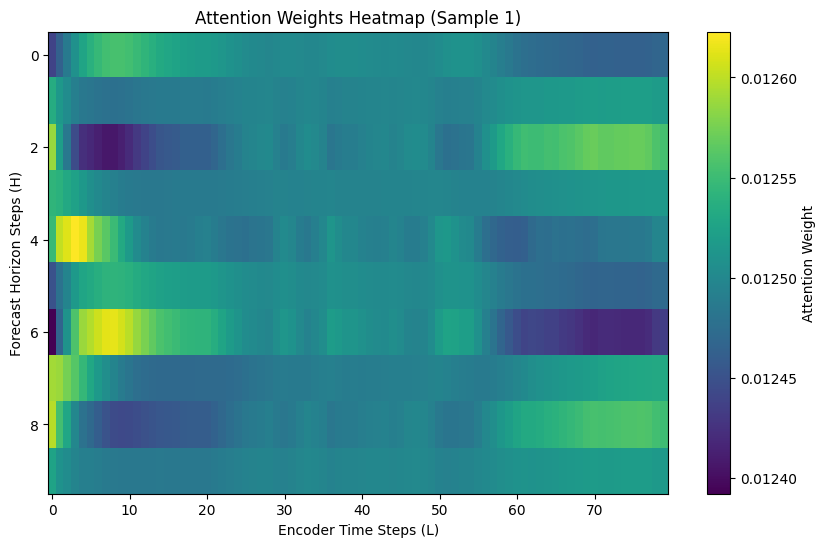

In [24]:
# ============================================================
# Section 8: Attention Weights Visualization (Fixed)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input

def build_attention_probe(L, H, units=128):
    enc_inputs = Input(shape=(L,1))
    enc_out, state_h, state_c = layers.LSTM(
        units, return_sequences=True, return_state=True
    )(enc_inputs)

    dec_h, dec_c = state_h, state_c
    attn_weights = []

    for _ in range(H):
        context, alpha = BahdanauAttention(units)(enc_out, dec_h)
        # Ensure alpha has shape (batch, 1, L)
        alpha_exp = layers.Reshape((1,L))(alpha)
        attn_weights.append(alpha_exp)
        context_exp = layers.Reshape((1, units))(context)
        _, dec_h, dec_c = layers.LSTM(units, return_state=True)(
            context_exp, initial_state=[dec_h, dec_c]
        )

    # Concatenate attention weights along horizon axis -> (batch, H, L)
    attn_matrix = layers.Concatenate(axis=1)(attn_weights)
    return Model(enc_inputs, attn_matrix)

# Build probe model
attn_probe = build_attention_probe(L, H, units=128)

# Pick one test sample
sample_idx = 0
X_sample = X_test[sample_idx:sample_idx+1]

# Get attention weights (shape: (1, H, L))
attn_w = attn_probe.predict(X_sample)

# Plot heatmap
plt.figure(figsize=(10,6))
plt.imshow(attn_w.squeeze(), aspect='auto', cmap='viridis')
plt.colorbar(label="Attention Weight")
plt.xlabel("Encoder Time Steps (L)")
plt.ylabel("Forecast Horizon Steps (H)")
plt.title(f"Attention Weights Heatmap (Sample {sample_idx+1})")
plt.show()

In [25]:
# ============================================================
# Section 9: Model Evaluation
# ============================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Flatten arrays for metric calculation
y_true = Y_test_inv.reshape(-1)
y_pred_vanilla = pred_vanilla_inv.reshape(-1)
y_pred_attn = pred_attn_inv.reshape(-1)

# Compute metrics
rmse_vanilla = np.sqrt(mean_squared_error(y_true, y_pred_vanilla))
mae_vanilla  = mean_absolute_error(y_true, y_pred_vanilla)

rmse_attn = np.sqrt(mean_squared_error(y_true, y_pred_attn))
mae_attn  = mean_absolute_error(y_true, y_pred_attn)

# Print results
print("Vanilla Seq2Seq LSTM Performance:")
print(f"  RMSE: {rmse_vanilla:.4f}")
print(f"  MAE : {mae_vanilla:.4f}")

print("\nAttention Seq2Seq LSTM Performance:")
print(f"  RMSE: {rmse_attn:.4f}")
print(f"  MAE : {mae_attn:.4f}")

Vanilla Seq2Seq LSTM Performance:
  RMSE: 2.8349
  MAE : 1.7338

Attention Seq2Seq LSTM Performance:
  RMSE: 2.7479
  MAE : 1.8375


Performance Comparison Table:
                    Model      RMSE       MAE
0    Vanilla Seq2Seq LSTM  2.834926  1.733845
1  Attention Seq2Seq LSTM  2.747895  1.837540


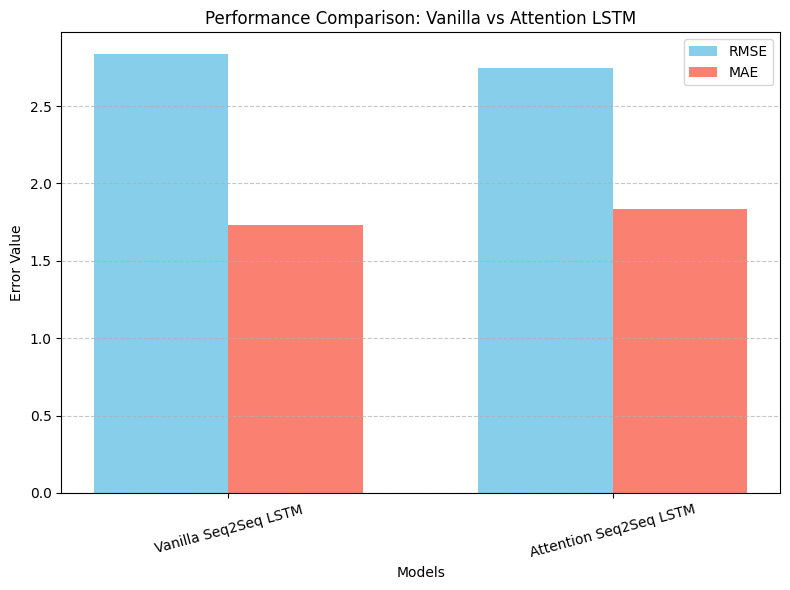

In [26]:
# ============================================================
# Section 10: Performance Comparison Summary
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame with results
results = pd.DataFrame({
    "Model": ["Vanilla Seq2Seq LSTM", "Attention Seq2Seq LSTM"],
    "RMSE": [rmse_vanilla, rmse_attn],
    "MAE": [mae_vanilla, mae_attn]
})

print("Performance Comparison Table:")
print(results)

# Plot bar chart comparison
plt.figure(figsize=(8,6))
bar_width = 0.35
index = np.arange(len(results))

plt.bar(index, results["RMSE"], bar_width, label="RMSE", color="skyblue")
plt.bar(index + bar_width, results["MAE"], bar_width, label="MAE", color="salmon")

plt.xlabel("Models")
plt.ylabel("Error Value")
plt.title("Performance Comparison: Vanilla vs Attention LSTM")
plt.xticks(index + bar_width/2, results["Model"], rotation=15)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()